In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.backends.backend_pdf as backend_pdf
import matplotlib.pyplot as plt
import arviz
import seaborn as sns
from ete3 import Tree
import argparse
import arviz as az
import gc


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Diagnostics notebook

In [7]:
#  this will be read in as variable from the script.. 
MCMC_iter = 6000
burnin = 2000
nthin = 1 # see from script/running conditions, not used for plotting
folder_runs = '_sim-30-leaves/runs_v2/78241558624040307/'#'_sim-30-leaves/runs_v2/15287225176595236/'
folder_simdata = '_sim-30-leaves/simdata/78241558624040307/' #'BM9/simdata/3513656273068705/' #args.folder_simdata +'/'
nnodes = 59
nxd=40
levelorder_tree = 'levelorder_chazot_full_tree.nw'
pars_name = ['kalpha', 'gtheta']
rep_path = len(pars_name)+1
chains = os.listdir(folder_runs) # use all chains in data seed folder 
chains = [c for c in chains if c[0] not in ['_', '.', 'leaves']] # remove files starting with underscore
print(chains)
temp_name = ['' for i in range(len(chains))]


['magic-leaf-531', 'young-sky-529', 'expert-shadow-529']


In [8]:
# read in data and MCMC chains
raw_trees = [np.genfromtxt(folder_runs + chains[i]+'/'+temp_name[i]+"tree_nodes.csv", delimiter = ",") for i in range(len(chains))]
tree_counters = [np.genfromtxt(folder_runs + chains[i]+'/'+temp_name[i]+"tree_counter.csv", delimiter = ",").astype(int) for i in range(len(chains))]
flat_trees_raw = [raw_trees[i].reshape(len(tree_counters[i]),nnodes,nxd) for i in range(len(raw_trees))]
flat_true_tree = np.genfromtxt(folder_simdata+"flat_true_tree.csv", delimiter = ",")
super_root = [np.genfromtxt(folder_runs + chains[i]+'/'+temp_name[i]+"inference_root_start.csv", delimiter = ",") for i in range(len(chains))]
_super_root = [np.concatenate((super_root[i], super_root[i][0:2])) for i in range(len(chains))]
_super_root = np.unique(np.array(_super_root), axis=0)


# In[12]:
flat_trees = np.array([np.repeat(flat_trees_raw[i], tree_counters[i], axis=0)[burnin*rep_path:(MCMC_iter//nthin)*rep_path] for i in range(len(flat_trees_raw))])
flat_trees.shape

(3, 12000, 59, 40)

In [9]:
# create output folder
outputfolder = folder_runs
path = outputfolder+'_*'+'-'.join(chains)
if not os.path.isdir(path): 
    os.mkdir(path)
    os.mkdir(path+'/stats')


# get levelorder tree 
levelorder_tree = Tree(levelorder_tree)
leafidx = []
for leaf in levelorder_tree:
    leafidx.append(leaf.name)
print(leafidx)

# get innernode idx 
# nnodes: small tree = 9, large tree = 59
leafidxint = [int(leafidx[i]) for i in range(len(leafidx))]
nodes = list(range(nnodes))
inneridx = list(set(nodes)-set(leafidxint))


['3', '4', '11', '17', '18', '19', '20', '27', '28', '29', '39', '40', '9', '31', '41', '42', '33', '43', '44', '35', '45', '46', '47', '51', '52', '53', '54', '55', '57', '58']


## Evaluate statistics for paths 

In [ ]:
# EVALUATE STATISTICS FOR PLOTTING
ft_=flat_trees.reshape(-1, nnodes, nxd)
mean_est = np.mean(ft_, axis=0)
median_est = np.median(ft_, axis=0)
#mode_est = mode(ft_, axis=0)[0]

# evaluate MSEs
squared_error_mean = (flat_true_tree-mean_est)**2
squared_error_median = (flat_true_tree-median_est)**2
#squared_error_mode = (flat_true_tree-mode_est)**2

# evaluate bias 
bias_mean = (flat_true_tree-mean_est)
bias_median = (flat_true_tree-median_est)
#bias_mode = (flat_true_tree-mode_est)

# save statistics for final plots
#np.savetxt(path+'/'+f"squared_error_mean.csv",squared_error_mean, delimiter=",")
#np.savetxt(path+'/'+"squared_error_median.csv",squared_error_median, delimiter=",")
#np.savetxt(path+'/'+"squared_error_mode.csv",squared_error_mode, delimiter=",")
#np.savetxt(path+'/'+"bias_mean.csv",bias_mean, delimiter=",")
#np.savetxt(path+'/'+"bias_median.csv",bias_median, delimiter=",")
#np.savetxt(path+'/'+"bias_mode.csv",bias_mode, delimiter=",")

## Gelman-Rubin convergence diagnostics

In [10]:

# get rhat and ESS for all nodes and dimensions
rhats = []
esss = []
for idx in range(flat_trees.shape[2]):  # calculate for all nodes 
    innernodes = flat_trees[:,:,idx, :]
    keys = list(range(innernodes.shape[2]))
    MCMCres = arviz.convert_to_dataset({k:innernodes[:,:,i] for i,k in enumerate(keys)})
    rhats.append(arviz.rhat(MCMCres).to_array().to_numpy())
    esss.append(arviz.ess(MCMCres).to_array().to_numpy())

# save rhat for plotting
np.savetxt(path+'/stats/'+"rhats_paths.csv",np.array(rhats), delimiter=",")

## Define plotting functions 

In [ ]:
def plot_traces_tree(flat_true_tree, flat_trees, inneridx, ess, rhats, outpath = path + f'/trace-innernodes_burnin={burnin}_MCMCiter={MCMC_iter}.pdf'): 
    colors = sns.color_palette('pastel', flat_trees.shape[0])
    print(outpath)
    pdf = backend_pdf.PdfPages(outpath)
    plt.figure(1)
    for idx in inneridx: # loop over innernodes
        fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(25,15), sharex=True)
        for j in range(flat_trees.shape[0]): # loop over chains
            innernode = flat_trees[j,:,idx, :]
            true_innernode = flat_true_tree[idx,:]
            curcol = colors[j]
            for i, ax in zip(range(innernode.shape[1]), axes.flat): # loop over dimensions
                ax.plot(innernode[:,i], color = curcol, alpha=0.5)
                ax.hlines(y=true_innernode[i], xmin=0, xmax=innernode.shape[0], color='skyblue')
                cur_ess = ess[idx][i]
                cur_rhat = rhats[idx][i]
                ax.set_title(f'{i}, Rhat={round(cur_rhat,2)}, ESS: {round(cur_ess,2)}')
        fig.suptitle(f'Node {idx}', size=40)
        pdf.savefig()
        plt.clf()
    pdf.close();

In [ ]:
def summary_rhat(rhats, inneridx, outpath):
    # plot summary of Rhat values 
    n_nodes = len(inneridx)
    print(n_nodes)
    # Determine the grid size
    grid_size = int(np.ceil(np.sqrt(n_nodes)))

    # Create subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20), sharex=True, sharey=True)
    fig.suptitle(r'$\hat{R}$ for all innernodes')

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Create a scatter plot for each k
    for i in range(n_nodes):
        sns.violinplot(rhats[inneridx[i]], ax=axes[i])
        axes[i].hlines(y=1.1, xmin=-0.5, xmax=0.5, color='red', linestyle='--')
        axes[i].set_title(f'Node={list(inneridx)[i]}')

    # Hide any unused subplots
    for j in range(n_nodes, grid_size * grid_size):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(outpath)
    fig.subplots_adjust(top=0.95)
    plt.show()
    plt.close()
    gc.collect()

In [ ]:
def plot_posterior(flat_trees, inneridx, outpath, flat_true_tree=False, sample_n=50):
    # plot summary of Rhat values 
    n_nodes = len(inneridx)
    # Determine the grid size
    grid_size = int(np.ceil(np.sqrt(n_nodes)))
    # Create subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20), sharex=True, sharey=True)
    fig.suptitle(f'Samples from posterior (every {sample_n}) for all innernodes', size=20)
    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Create a scatter plot for each k
    for i in range(n_nodes):
        idx = inneridx[i]
        innernodes = flat_trees[:,:,idx,:].reshape(-1, nxd)[::sample_n,:]
        inode = np.append(innernodes, innernodes[:,0:2],1)
        for j in range(inode.shape[0]):
            axes[i].plot(inode[j,::2], inode[j,1::2], '--.', color='steelblue', alpha=0.3)
        if flat_true_tree is not False:
            true_innernode = flat_true_tree[idx,:]
            tinode = np.concatenate((true_innernode, true_innernode[0:2]))  
            axes[i].plot(tinode[::2], tinode[1::2], '--.', color='black', label='True shape')
        axes[i].set_title(f'Node {idx}', size=10);

    # Hide any unused subplots
    for j in range(n_nodes, grid_size * grid_size):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(outpath)
    fig.subplots_adjust(top=0.95)
    plt.show()
    plt.close()
    gc.collect()

In [ ]:
def plot_leaves(flat_true_tree, leafidx, outpath):
    # plot summary of Rhat values 
    n_nodes = len(leafidx)
    # Determine the grid size
    grid_size = int(np.ceil(np.sqrt(n_nodes)))
    # Create subplots
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20), sharex=True, sharey=True)
    fig.suptitle(f'Observed data (i.e. leaves)', size=20)
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    root = flat_true_tree[0,:]
    # Create a scatter plot for each k
    for i in range(n_nodes):
        idx = leafidx[i]
        leaf = flat_true_tree[idx,:]
        leafp = np.append(leaf, leaf[0:2],0)
        axes[i].plot(leafp[::2], leafp[1::2], '--.', color='orange', lw=2)
        #rootp = np.concatenate((root, root[0:2]))  
        #axes[i].plot(rootp[::2], rootp[1::2], '--.', color='black', label='Root')
        #axes[i].set_title(f'Node {idx}', size=10);

    # Hide any unused subplots
    for j in range(n_nodes, grid_size * grid_size):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(outpath)
    fig.subplots_adjust(top=0.95)
    plt.show()
    plt.close()
    gc.collect()

In [ ]:
def get_mode(all_chains, bw='silverman'): 
    '''Function for marginal mode estimation '''
    mode_est = []
    for i in range(all_chains.shape[1]):
        kdes = az.kde(all_chains[:,i].flatten(), bw=bw)
        mest = kdes[0][np.where(kdes[1] == max(kdes[1]))[0][0]]
        mode_est.append(mest)
    mode_est = np.array(mode_est)
    return(mode_est)

## Plot traces and diagnostics paths

In [ ]:
plot_traces_tree(flat_true_tree, flat_trees, inneridx, esss, rhats, outpath = path + f'/trace-innernodes_burnin={burnin}_MCMCiter={MCMC_iter}.pdf')

In [ ]:
summary_rhat(rhats, inneridx, outpath = path + f'/summary_rhat_burnin={burnin}_MCMCiter={MCMC_iter}.pdf')

In [ ]:
sns.violinplot(np.array(rhats).flatten())
plt.hlines(y=1.1, xmin=-0.5, xmax=0.5, color='red', linestyle='--')
plt.savefig(path + f'/summary_rhat_allnodes_burnin={burnin}_MCMCiter={MCMC_iter}.pdf')

## Plot posterior path

In [ ]:
plot_posterior(flat_trees, inneridx, outpath = path + f'/posterior_samples_burnin={burnin}_MCMCiter={MCMC_iter}.pdf', flat_true_tree=flat_true_tree, sample_n=50)

## Plot leaves 

In [ ]:
plot_leaves(flat_true_tree, leafidxint, outpath = path + f'/leaves_burnin={burnin}_MCMCiter={MCMC_iter}.pdf')

## Plot parameters 

In [ ]:
par = pars_name[0]
o = [np.genfromtxt(folder_runs + chains[i]+'/'+par+"s.csv", delimiter = ",")[:MCMC_iter] for i in range(3)]
o[1].shape

In [ ]:
raw_pars = np.array([[np.genfromtxt(folder_runs + chains[i]+'/'+par+"s.csv", delimiter = ",")[:MCMC_iter] for i in range(len(chains))] for par in pars_name])
#raw_acceptpars = np.array([[np.genfromtxt(folder_runs + chains[i]+'/'+temp_name[i]+f"accept{par}.csv", delimiter = ",") for i in range(len(chains))] for par in pars_name])
true_pars = [np.genfromtxt(folder_simdata +p+"_sim.csv", delimiter = ",") for p in pars_name]

In [ ]:
pars = raw_pars[:,:,burnin:MCMC_iter]
pars.shape
#acceptpars = raw_acceptpars[:,:,burnin:MCMC_iter]
#acceptance_rate = np.mean(acceptpars, axis=2) # add when neccesary information is stored 

In [ ]:
parsdict = dict(zip(pars_name, pars)) 
MCMC_result = parsdict 
parsres = arviz.convert_to_dataset(MCMC_result)
rhat = arviz.rhat(parsres)
mcse = arviz.mcse(parsres)
ess = arviz.ess(parsres)
arviz.summary(parsres)

# save rhat for plotting
rhats_par = np.array([rhat['kalpha'], rhat['gtheta']])
np.savetxt(path+'/stats/'+"rhats_pars.csv",np.array(rhats_par), delimiter=",")

true_vals = true_pars #[true_pars]
keys = pars_name
print(keys)
print(true_vals)
print([pars[i].shape for i in range(len(pars))])
print(keys)

In [ ]:
# EVALUATE STATISTICS FOR PLOTTING
#ft_=flat_trees.reshape(-1, nnodes, nxd)
pars_ = np.array([pars[0].flatten(), pars[1].flatten()])
mean_est = np.mean(pars_, axis=1)
median_est = np.median(pars_, axis=1)
mode_est_sm = get_mode(pars_.T, bw='silverman') 
mode_est_isj = get_mode(pars_.T, bw='isj') 

# evaluate MSEs
squared_error_mean = (true_pars-mean_est)**2
squared_error_median = (true_pars-median_est)**2
squared_error_mode_sm = (true_pars-mode_est_sm)**2
squared_error_mode_isj = (true_pars-mode_est_isj)**2

# evaluate bias 
bias_mean = (true_pars-mean_est)
bias_median = (true_pars-median_est)
bias_mode_sm = (true_pars-mode_est_sm)
bias_mode_isj = (true_pars-mode_est_isj)

# save statistics for final plots
np.savetxt(path+'/stats/'+"squared_error_mean_pars.csv",squared_error_mean, delimiter=",")
np.savetxt(path+'/stats/'+"squared_error_median_pars.csv",squared_error_median, delimiter=",")
np.savetxt(path+'/stats/'+"squared_error_mode_pars_sm.csv",squared_error_mode_sm, delimiter=",")
np.savetxt(path+'/stats/'+"squared_error_mode_pars_isj.csv",squared_error_mode_isj, delimiter=",")
np.savetxt(path+'/stats/'+"bias_mean_pars.csv",bias_mean, delimiter=",")
np.savetxt(path+'/stats/'+"bias_median_pars.csv",bias_median, delimiter=",")
np.savetxt(path+'/stats/'+"bias_mode_pars_sm.csv",bias_mode_sm, delimiter=",")
np.savetxt(path+'/stats/'+"bias_mode_pars_isj.csv",bias_mode_isj, delimiter=",")

In [ ]:
keys = ['kalpha', 'gtheta']
colors = sns.color_palette('pastel', len(chains))
fig, axes = plt.subplots(nrows=len(keys), ncols=2, figsize=(20,10), sharex=False)
p = 0
for i, ax in zip(range(len(axes.flat)), axes.flat): 
        if i%2 == 0: 
            for j in range(pars[p].shape[0]): #loop over chains 
                ax.plot(pars[p][j,:], color=colors[j], alpha=0.5)
            ax.hlines(y=true_vals[p], xmin=0, xmax=pars[p].shape[1], color='skyblue')
            if keys[p] == 'kalpha':
                ax.set_title(r'${\alpha}$,'+r' $\hat{R}$: ' + f'{round(float(np.array(rhat[keys[p]])),2)} \n (ESS: {round(float(np.array(ess[keys[p]])),2)}) ')
            if keys[p] == 'gtheta':
                ax.set_title(r'${\sigma}$,'+r' $\hat{R}$: ' + f'{round(float(np.array(rhat[keys[p]])),2)} \n (ESS: {round(float(np.array(ess[keys[p]])),2)}) ')
        else:
            for j in range(pars[p].shape[0]):
                sns.kdeplot(pars[p][j,:], ax=ax)
                sns.rugplot(pars[p][j,:], ax=ax)
            ax.axvline(x = true_vals[p], ymin = 0, ymax = 1, color='orange', label='true value')
            #ax.axvline(x = mode_est_isj[p], ymin = 0, ymax = 1, color='purple', label='isj')
            #ax.axvline(x = mode_est_sm[p], ymin = 0, ymax = 1, color='green', label='silverman')
            #ax.axvline(x = mean_est[p], ymin = 0, ymax = 1, color='skyblue', label='mean')     
            #ax.axvline(x = median_est[p], ymin = 0, ymax = 1, color='grey', label='median')
            #ax.set_title(f'{keys[p]}, rhat: {round(float(np.array(rhat[keys[p]])),2)} \n (ESS: {round(float(np.array(ess[keys[p]])),2)}) ')#
            if keys[p] == 'kalpha':
                ax.set_title(r'${\alpha}$,'+r' $\hat{R}$: ' + f'{round(float(np.array(rhat[keys[p]])),2)} \n (ESS: {round(float(np.array(ess[keys[p]])),2)}) ')
            if keys[p] == 'gtheta':
                ax.set_title(r'${\sigma}$,'+r' $\hat{R}$: ' + f'{round(float(np.array(rhat[keys[p]])),2)} \n (ESS: {round(float(np.array(ess[keys[p]])),2)}) ')
            p+=1
            #ax.legend(loc='upper right')
#fig.suptitle(f"Iter: {MCMC_iter}, Burnin: {burnin} \n", fontsize=15)
fig.tight_layout()
fig.savefig(path+f'/pars_burnin={burnin}_MCMCiter={MCMC_iter}.pdf')



## Create images for plotting of posterior


In [ ]:

for i in range(leaves.shape[0]): 
    leaf = leaves[i,:]
    leafp = np.append(leaf, leaf[0:2],0)
    plt.plot(leafp[::2], leafp[1::2], '--.', color='black', lw=2)
    plt.ylim(-0.9,1.1)
    plt.xlim(-1.1, 1.3)
    plt.axis('off')
    plt.savefig(folder_runs+f'leaves/{leafidxint[i]}.pdf')
    plt.show()
    

# create images for visualization of posterior

In [31]:
inneridx

[0,
 1,
 2,
 5,
 6,
 7,
 8,
 10,
 12,
 13,
 14,
 15,
 16,
 21,
 22,
 23,
 24,
 25,
 26,
 30,
 32,
 34,
 36,
 37,
 38,
 48,
 49,
 50,
 56]

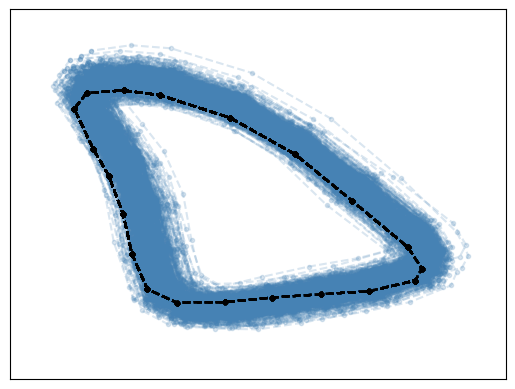

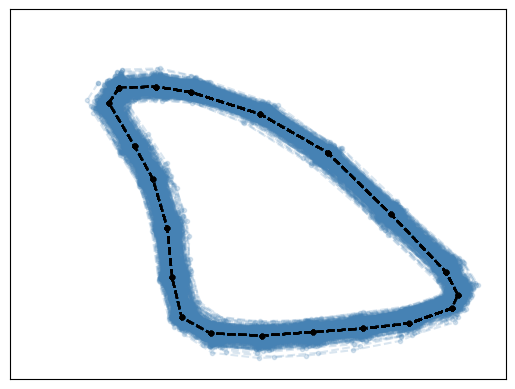

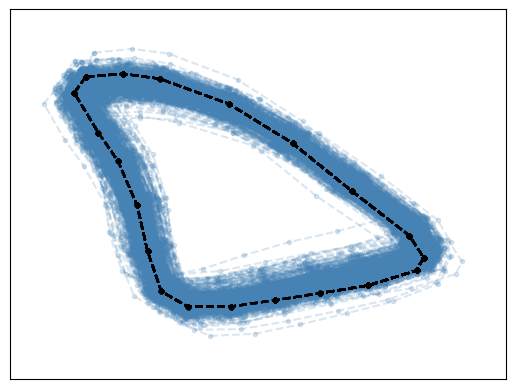

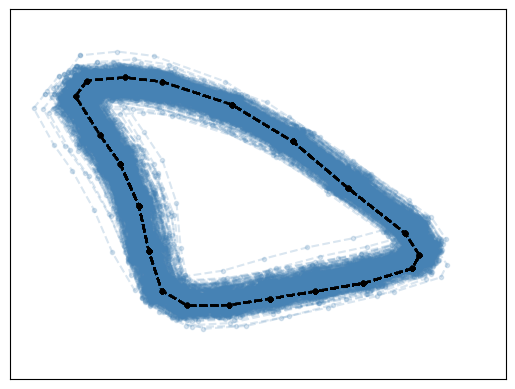

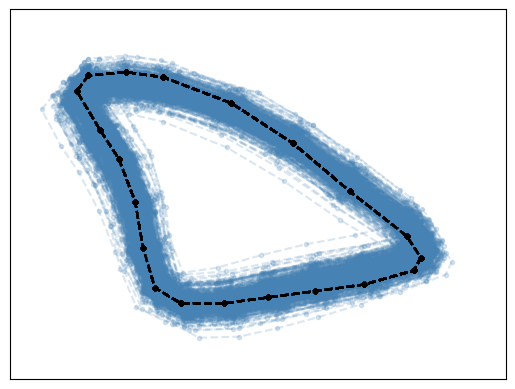

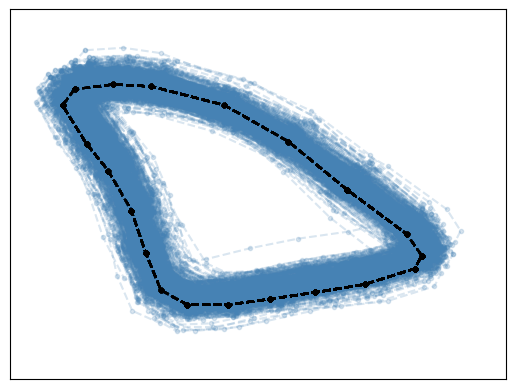

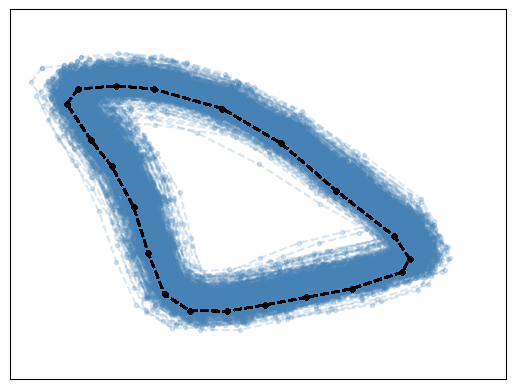

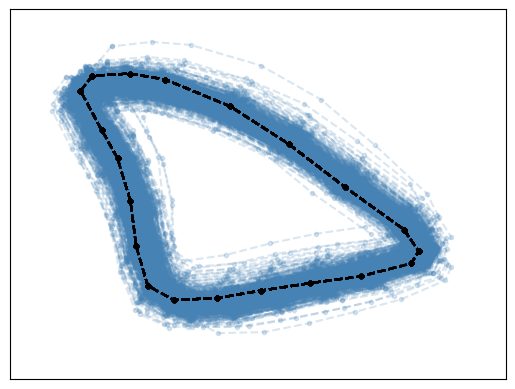

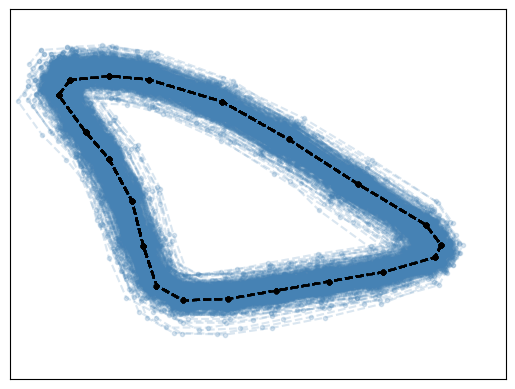

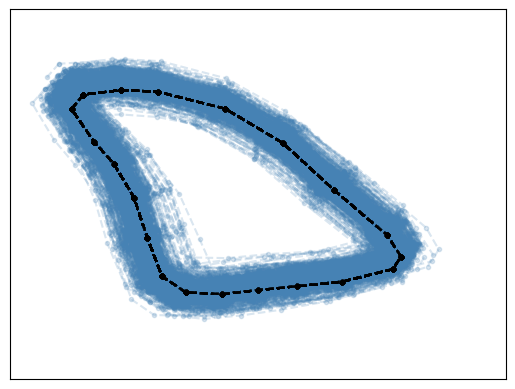

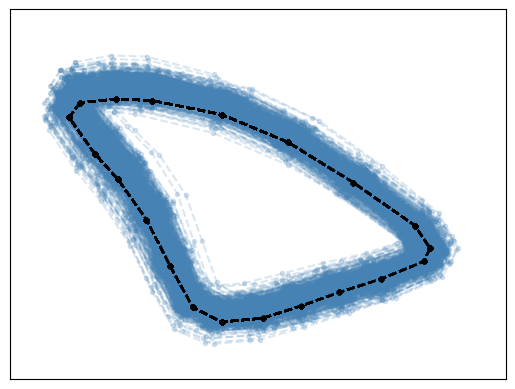

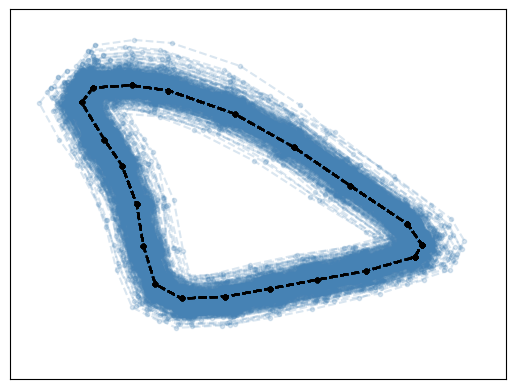

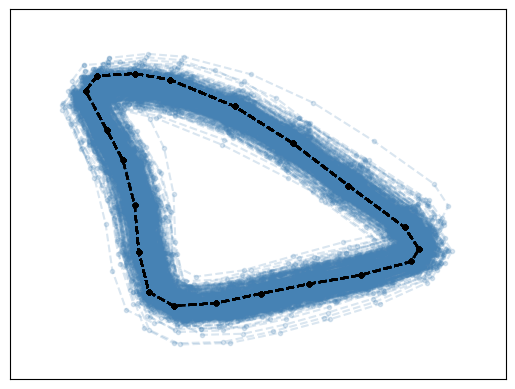

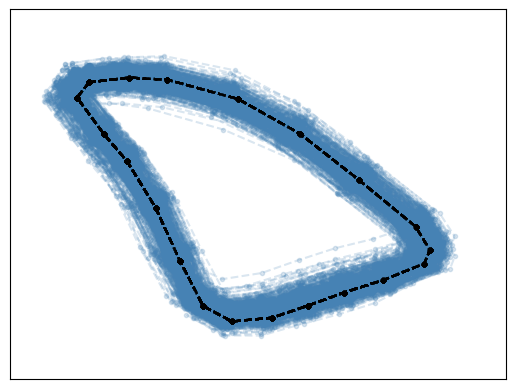

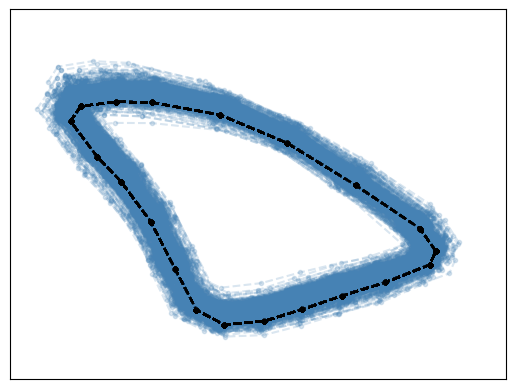

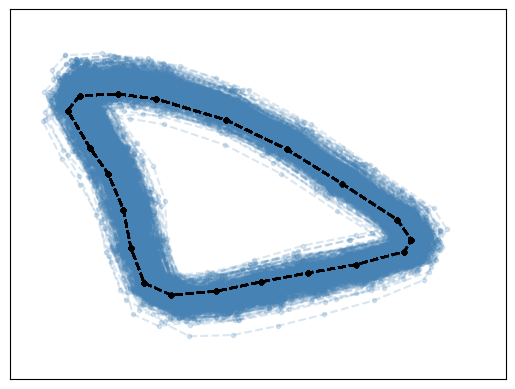

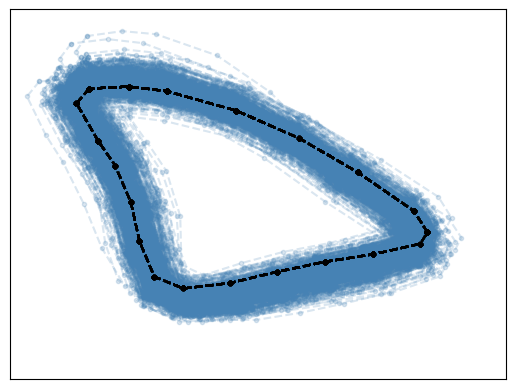

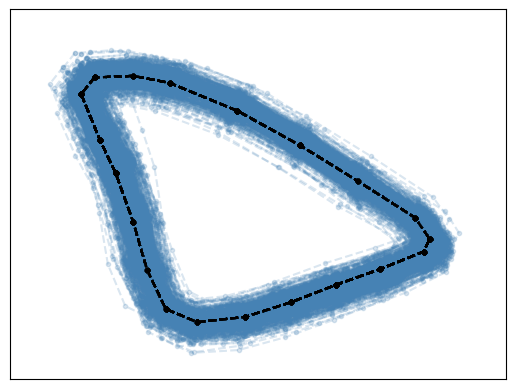

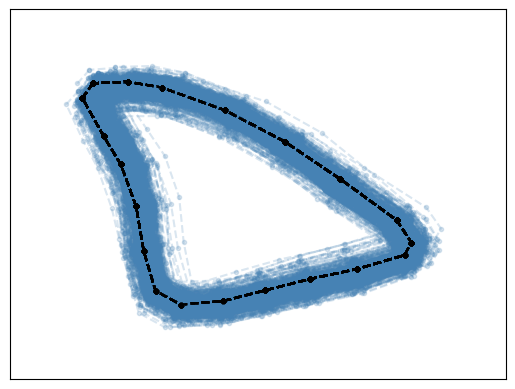

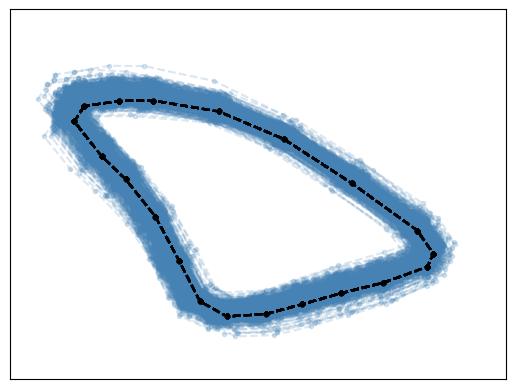

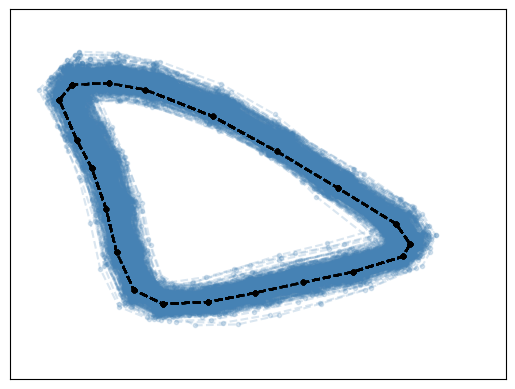

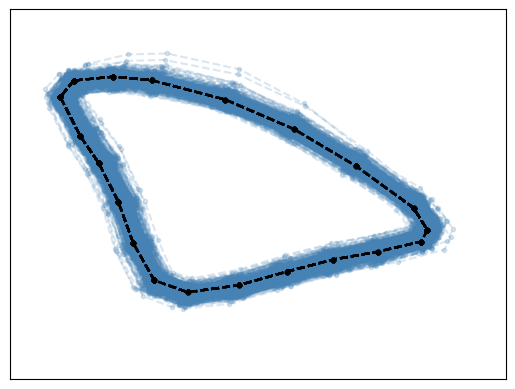

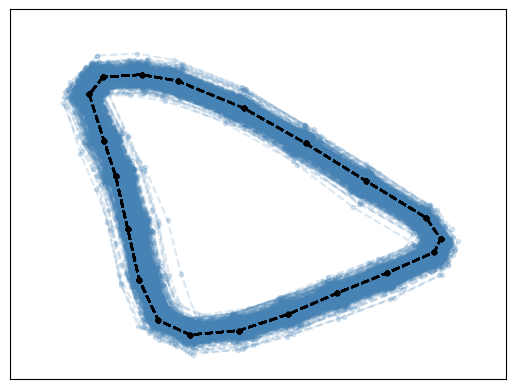

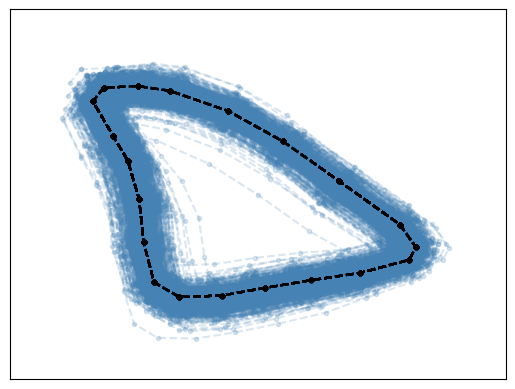

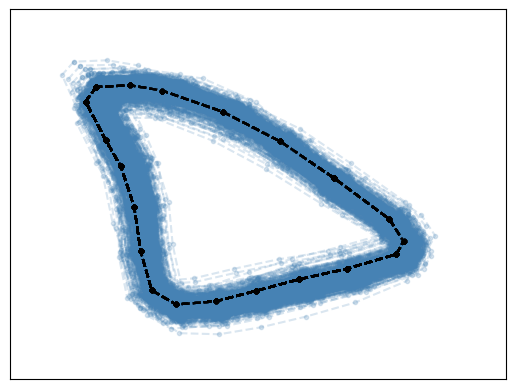

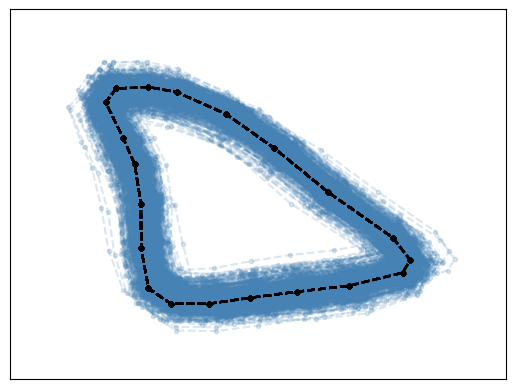

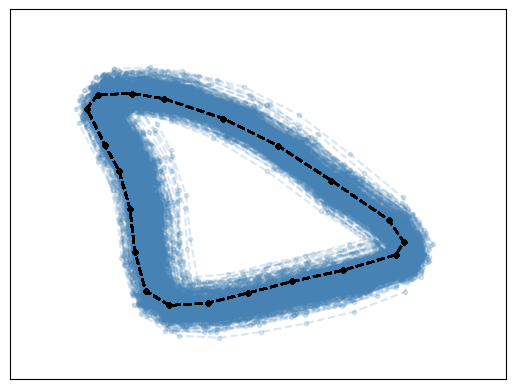

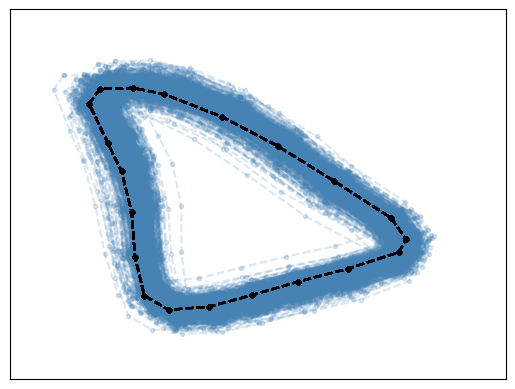

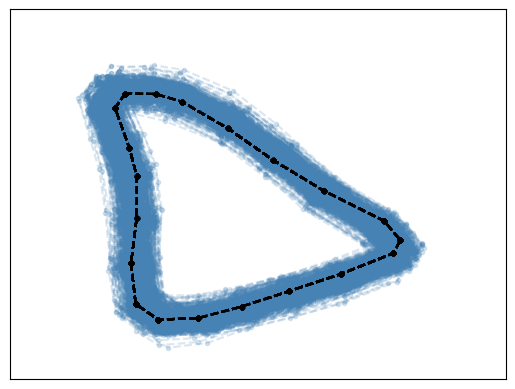

In [39]:
# Create a scatter plot for each k
sample_n=50
for i in range(len(inneridx)):
    idx = inneridx[i]
    innernodes = flat_trees[:,:,idx,:].reshape(-1, nxd)[::sample_n,:]
    inode = np.append(innernodes, innernodes[:,0:2],1)
    for j in range(inode.shape[0]):
        plt.plot(inode[j,::2], inode[j,1::2], '--.', color='steelblue', alpha=0.2)
        true_innernode = flat_true_tree[idx,:]
        tinode = np.concatenate((true_innernode, true_innernode[0:2]))  
        plt.plot(tinode[::2], tinode[1::2], '--.', color='black', label='True shape')
    #plt.title(f'Node {idx}', size=10)
    #plt.axis('off')
    plt.ylim(-1.1,1.3)
    plt.xlim(-1.2, 1.5)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.savefig(folder_runs+f'innernodes/{inneridx[i]}.pdf')
    plt.show()
    


